# Diffusivity measurement

In this notebook, we use 1d diffusion experiment to measure the diffusivity of methylene blue in a gel.

First we import Python modules:

In [1]:
# Python imports
import os
from natsort import natsorted, ns

import numpy as np

from skimage import io
from skimage.util import img_as_float

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ipywidgets import interactive, IntRangeSlider, IntSlider

from tqdm.notebook import tqdm

from scipy.special import erfc
from scipy.optimize import curve_fit

Then we define parameters for getting the images:

In [2]:
# folder containing the images. This should be the relative path from the python
# script.
folder = 'images'

# Reference image Python index (for example, if reference image is the first of the stack,
# leave as 0)
ref_index = 0

# Last image to take (None to take the last image)
ref_end = None

# Number of images to skip (use non-zero for testing or to speed-up processing)
skip = 0

Finally we have the physics:

In [3]:
# pixels per cm
pxpcm = 367

# Time step between images (min)
dt = 1.

# Molar extinction coefficient (cm^-1 L/mol)
epsilon = 2900.

# Methylene blue molar mass (g mol^-1)
M = 319.85

# Optical path length in cuvette (cm)
L = 1.

Let's see how many images we can import:

In [4]:
# Get images names. 'natsorted' function will sort the names by 'natural' order,
# for example if there is a suffix with image number or timestamp.
list_files = natsorted(os.listdir(folder))

# Trim list
list_files = list_files[ref_index:ref_end:skip+1]
print(f"Reference image name: {list_files[0]}")
print(f"Number of images in stack: {len(list_files)}")

Reference image name: Basler_acA1920-150um__40076601__20210625_111921978_2.tiff
Number of images in stack: 719


## Select the area of interest

Use slider handles or select and overwrite values next to each the slider.

In [5]:
# Cropping
im0 = img_as_float(io.imread(f"{folder}/{list_files[0]}"))
y_max, x_max = im0.shape
def crop(horizontal,vertical):
    im = im0[vertical[0]:vertical[1],horizontal[0]:horizontal[1]]
    
    rect = patches.Rectangle([horizontal[0], vertical[0]], horizontal[1]-horizontal[0], vertical[1]-vertical[0], linewidth=1, edgecolor='r', facecolor='none')
    
    plt.rcParams["figure.figsize"] = (15,10)
    figure, ax = plt.subplots(ncols=2)
        
    ax[0].imshow(im0, cmap='gray')
    ax[0].add_patch(rect)
    ax[0].set_title('Original image')

    ax[1].imshow(im, cmap='gray')
    ax[1].set_title('Cropped image')
    plt.show()
    
    return im

# Check for previously used values
import pickle
try:
    cuvette = pickle.load(open(".cuvette.pickle", "rb" ))
except FileNotFoundError:
    cuvette = {'horizontal': (0, x_max), 'vertical': (0, y_max)}

w = interactive(crop, horizontal=IntRangeSlider(value=[cuvette['horizontal'][0], cuvette['horizontal'][1]],min=0,max=x_max, continuous_update=False),
                       vertical=IntRangeSlider(value=[cuvette['vertical'][0], cuvette['vertical'][1]],min=0,max=y_max, continuous_update=False))
w

interactive(children=(IntRangeSlider(value=(1080, 1140), continuous_update=False, description='horizontal', ma…

In [6]:
# Store selected value between runs
pickle.dump(w.kwargs, open(".cuvette.pickle", "wb"))

## Load images

Images of the stack will be loaded, cropped and stored in an array of images for further processing.

In [7]:
stack = np.empty((len(list_files), *w.result.shape))

for i, name in tqdm(enumerate(list_files), total=len(list_files)):

    # Load image as matrix of floats, values in [0,1]
    im = img_as_float(io.imread(f"{folder}/{name}"))
    # Crop and store
    stack[i] = im[w.kwargs['vertical'][0]:w.kwargs['vertical'][1],w.kwargs['horizontal'][0]:w.kwargs['horizontal'][1]]

  0%|          | 0/719 [00:00<?, ?it/s]

## Compute absorbance and concentration

We start with defining the absorbance and 'repare' outliers.

In [8]:
A = -np.log10(stack/stack[0])
A[np.isnan(A)] = 0.
A[A<0] = 0.

We compute the average along the horizontal axis, and convert it to concentration using Beer-Lambert's law:

In [9]:
A_avg = np.average(A, axis=2)
c = M*A_avg/epsilon/L              # in mg/mL

Let's inspect the result:

In [10]:
c_max = 0.1
x = np.arange(len(c[0]))/pxpcm     # in cm

def inspect(time):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(x, c[time])
    plt.ylim(0, c_max)
    plt.xlabel('x (cm)')
    plt.ylabel('c (mg/mL)')
    plt.show()
    
w2 = interactive(inspect, time=IntSlider(value=0,min=0,max=len(c)-1, continuous_update=False))
w2

interactive(children=(IntSlider(value=0, continuous_update=False, description='time', max=718), Output()), _do…

## Fit 1d diffusion model

If diffusion from a constrained concentration at $x=0$ (*well-stirred* reservoir hypothesis), then the analytical solution is:
$$
c(x,t) = c_0 \mathrm{erfc}\left( \frac{x}{\sqrt{4 D t}} \right)
$$
with $c_0=c(x=0)$, and $D$ is the diffusivity. We fit $\sigma = \sqrt{4 D t}$ independently in each profile:

In [11]:
x = np.arange(len(c[0]))/pxpcm     # in cm
c_0 = 0.07
sigmas = np.empty(len(c)-1)

for i in tqdm(range(1,len(c))):
    sigmas[i-1], pcov = curve_fit(lambda x, sigma: c_0*erfc(x/sigma), x, c[i])

  0%|          | 0/718 [00:00<?, ?it/s]

Let's inspect the result:

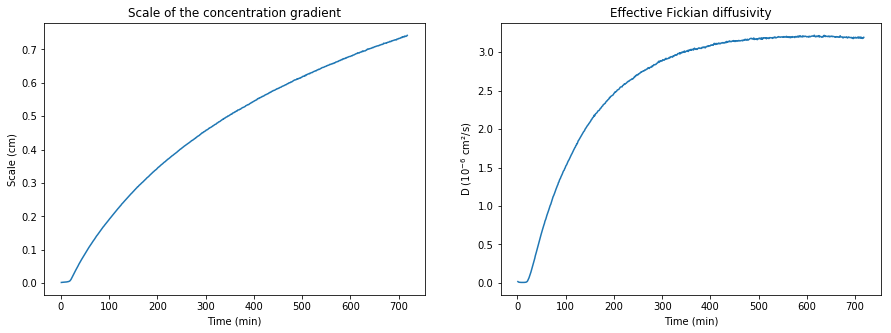

In [12]:
t = np.arange(1, len(c))*dt*(1+skip)
Ds = sigmas**2/4/t/60   # in cm²/s

figure, ax = plt.subplots(ncols=2)
ax[0].plot(t, sigmas)
ax[0].set_title('Scale of the concentration gradient')
ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Scale (cm)')

ax[1].plot(t, 1e6*Ds)
ax[1].set_title('Effective Fickian diffusivity')
ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('D ($10^{-6}$ cm²/s)')

plt.show()

## Save results in text files

In [40]:
np.savetxt('results.txt', np.hstack((t[:, None], sigmas[:, None], Ds[:, None])), header='# time (min),  scale (cm), diffusivity (cm²/s)')